In [1]:
import matplotlib.pyplot as plt
import numpy as np
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from netCDF4 import Dataset
from datetime import datetime, timedelta

# Precipitation Anomalies Maps

This notebook visualises **precipitation** anomalies for Europe and Northern Africa. I wish to plot quite recent data (December 2020 to August 2021), hence, I can't use [CRU TS](https://doi.org/10.1038/s41597-020-0453-3). Alternatively, the [ERA5](https://climatedataguide.ucar.edu/climate-data/era5-atmospheric-reanalysis) (atmospheric reanalysis) contains both temperature and precipitation data and is available until 2021/12. The dataset can be downloaded by request from the [Copernicus Climate Data Store](https://cds.climate.copernicus.eu/cdsapp#!/home).

In [2]:
# load data from netCDF file
era5_file = Dataset('../../data/ERA5/era5_global_tmp-pre_2000-21.nc')
print(era5_file)

<class 'netCDF4._netCDF4.Dataset'>
root group (NETCDF3_64BIT_OFFSET data model, file format NETCDF3):
    Conventions: CF-1.6
    history: 2022-03-22 12:43:58 GMT by grib_to_netcdf-2.24.2: /opt/ecmwf/mars-client/bin/grib_to_netcdf -S param -o /cache/data3/adaptor.mars.internal-1647952849.8090181-25999-3-2b1ddad9-3469-43a1-aea6-d57bf674b058.nc /cache/tmp/2b1ddad9-3469-43a1-aea6-d57bf674b058-adaptor.mars.internal-1647952700.8968768-25999-2-tmp.grib
    dimensions(sizes): longitude(3600), latitude(1801), time(264)
    variables(dimensions): float32 longitude(longitude), float32 latitude(latitude), int32 time(time), int16 t2m(time, latitude, longitude), int16 tp(time, latitude, longitude)
    groups: 


Accumulated liquid and frozen water, including rain and snow, that falls to the Earth's surface. It is the sum of large-scale precipitation (that precipitation which is generated by large-scale weather patterns, such as troughs and cold fronts) and convective precipitation (generated by convection which occurs when air at lower levels in the atmosphere is warmer and less dense than the air above, so it rises). Precipitation variables do not include fog, dew or the precipitation that evaporates in the atmosphere before it lands at the surface of the Earth. This variable is accumulated from the beginning of the forecast time to the end of the forecast step. The units of precipitation are depth in metres. It is the depth the water would have if it were spread evenly over the grid box. Care should be taken when comparing model variables with observations, because observations are often local to a particular point in space and time, rather than representing averages over a model grid box and model time step.

In [18]:
# get the data
# NOTE: taking every 10th coord due to computing power limitations
pre = era5_file.variables['tp'][:,::10,::10]*100
lon = era5_file.variables['longitude'][::10]
lat = era5_file.variables['latitude'][::10]
print(pre.shape)
print(lon.shape) # from -180 to 179
print(lat.shape) # from -90 to 90 (including 0°)

(264, 181, 360)
(360,)
(181,)


In [19]:
# import time var & convert into datetime object
time = era5_file.variables['time'][:]

dtime = []
start = datetime(1900, 1, 1)
for t in time:
    delta = timedelta(hours=int(t))
    dtime.append(start + delta)

In [20]:
# write function to get indices of time intervals as we'll need this a couple
# of times
def get_indices(start, end):
    iout = []
    for i, time in enumerate(dtime):
        if time >= start and time <= end:
            iout.append(i)
    return iout

In [21]:
# get indices of years 2000/01-2020/01, i.e., reference period
start = datetime(2000, 1, 1)
end = datetime(2019, 12, 31)
iavg = get_indices(start, end)

# compute AVERAGE precipitation per month per grid cell in reference period
pre_avg = []
iend = iavg[-1]    # index of last month in ref period
for istart in iavg[:12]:    
    # loop over first 12 indices, then, compute mean from first to last index
    # using every 12th value! To include last month of reference period use "iend+1".
    monthly_mean = np.mean(pre[istart:iend+1:12], axis=0)
    pre_avg.append(monthly_mean)    # returns list of arrays of shape (12, 181, 360)
np.shape(pre_avg)

(12, 181, 360)

In [22]:
# compute precipitation ANOMALY with index of month for 2020/12 to 2021/08
start = datetime(2020, 12, 1)
end = datetime(2021, 8, 1)
ianom = get_indices(start, end)

pre_anom = []
for i in ianom:
    imonth = dtime[i].month -1  # get index of month (e.g., Jan = 0, Dec = 11)
    monthly_anomaly = pre[i] - pre_avg[imonth]  # subtract respective month from tmp average
    pre_anom.append(monthly_anomaly)
np.shape(pre_anom)

(9, 181, 360)

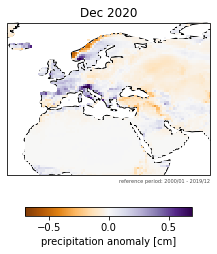

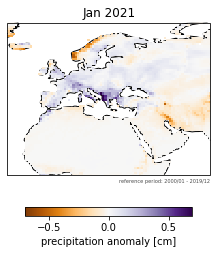

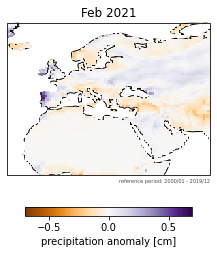

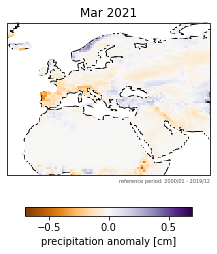

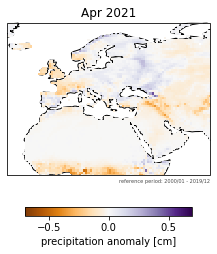

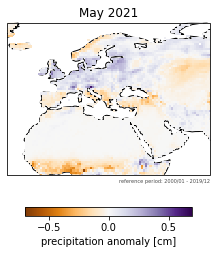

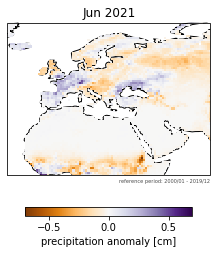

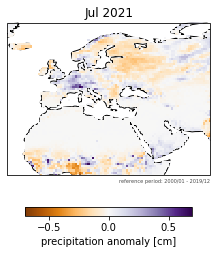

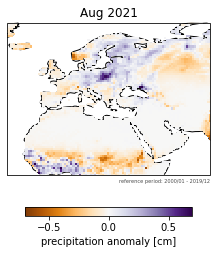

In [31]:
# plotting anomalies

# The data is defined in lat/lon coordinate system, so PlateCarree() is the
# appropriate transformation choice.
# (https://scitools.org.uk/cartopy/docs/latest/tutorials/understanding_transform.html)
data_crs = ccrs.PlateCarree()
v = 0.7

llon, llat = np.meshgrid(lon, lat)
for i, idate in enumerate(ianom):
    fig = plt.figure()
    ax = plt.axes(projection=ccrs.PlateCarree())
    ax.set_extent([-25, 70, 5, 70])
    ax.set_title(dtime[idate].strftime('%b %Y'))
    ax.add_feature(cfeature.COASTLINE)
    pcm = ax.pcolormesh(lon, lat, pre_anom[i], # alternatively: ax.contourf()
                        transform=data_crs, cmap='PuOr', vmin=-v, vmax=v)
    cb = fig.colorbar(pcm, orientation='horizontal', shrink=0.5)
    cb.set_label('precipitation anomaly [cm]')
    ax.text(0.55,-.05,'reference period: 2000/01 - 2019/12',
            {'fontsize': 5, 'alpha': 0.7},
            transform=plt.gca().transAxes) # in axis coordinates
    fig.savefig(
        f'../figs/dragonflies-catalonia/pre_{dtime[idate].year}-{dtime[idate].month}.png',
        dpi=600, bbox_inches='tight', facecolor='white',
    )

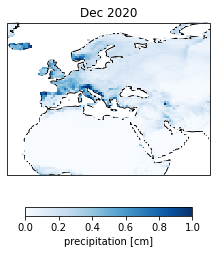

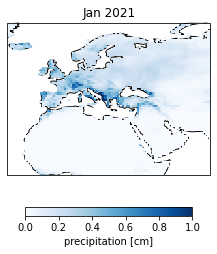

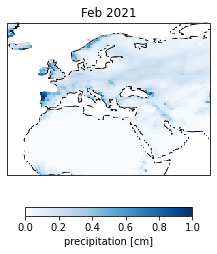

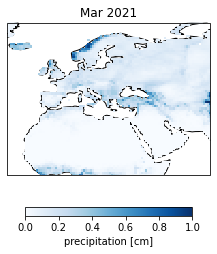

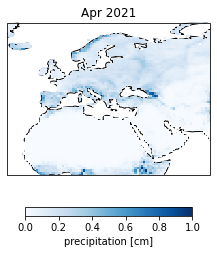

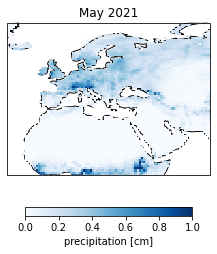

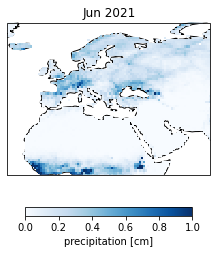

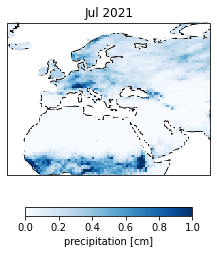

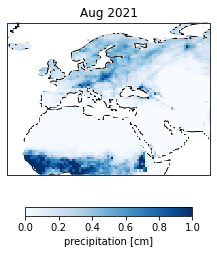

In [33]:
# plotting absolute precipitation
data_crs = ccrs.PlateCarree()

llon, llat = np.meshgrid(lon, lat)
for i in ianom:
    fig = plt.figure()
    ax = plt.axes(projection=ccrs.PlateCarree())
    ax.set_extent([-25, 70, 5, 70])
    ax.set_title(dtime[i].strftime('%b %Y'))
    ax.add_feature(cfeature.COASTLINE)
    pcm = ax.pcolormesh(lon, lat, pre[i], # alternatively: ax.contourf()
                        transform=data_crs, cmap='Blues', vmin=0, vmax=1)
    cb = fig.colorbar(pcm, orientation='horizontal', shrink=0.5)
    cb.set_label('precipitation [cm]')
    fig.savefig(
        f'../figs/dragonflies-catalonia/pre_{dtime[i].year}-{dtime[i].month}_abs.png',
        dpi=600, bbox_inches='tight', facecolor='white',
    )